In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdmolops
import entropy

In [2]:
def InPiStackFusedRing(mol,ringpair):
    """
    Label fused ring system in  Pi-Pi stacking ring pair
    
    """
    rpair = []
    rings = []
    indexpair = []
    groups = []
    for pair in ringpair:
        for ring in pair:
            if list(set(ring)) not in rings:
                rings.append(list(set(ring)))
    for pair in ringpair:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pair[0], pair[1])
        check = [len(set(shortest_path).intersection(set(r)))>1 for r in rings]
        if any(check):
            idx = [i for i,j in enumerate(check) if j]
            if any([len(set(rings[i]).intersection(set(pair[0])))>0 for i in idx]) or any([len(set(rings[i]).intersection(set(pair[1])))>0 for i in idx]):
                rpair.append((pair[0], pair[1],1))
            else:
                rpair.append((pair[0], pair[1],0))
        else:
            rpair.append((pair[0], pair[1],0))
    return rpair

In [5]:
# Load molecule with Pi-Pi stacking in training set
zinc_pi_stack = Chem.SDMolSupplier("zinc_pi_stack_train.sdf",removeHs=False)
cod_pi_stack = Chem.SDMolSupplier("cod_pi_stack_train.sdf",removeHs=False)
all_pi_stack = [mol for mol in zinc_pi_stack] + [mol for mol in cod_pi_stack]
unique_mol_pi_stack = []
inchis = []
# Some molecule in COD and ZINC overlap. Remove duplicates
for mol in all_pi_stack:
    inchi = Chem.MolToInchiKey(mol)
    if inchi not in inchis:
        inchis.append(inchi)
        unique_mol_pi_stack.append(mol)

In [6]:
len(unique_mol_pi_stack)

7887

<font size="5">We will study six functional groups here:  Carbamic Acid, Urea, Ketone, Ether, Ester and Amide</font>

# Carbamic Acid

In [7]:
# Carbamic Acid
carbamic_1 = Chem.MolFromSmarts("OC(=O)N") 
carbamic_mol = []
carbamic_mol_inchi = []
for mol in unique_mol_pi_stack:
    pistack = entropy.GetPiPiStacking(mol)
    inchi = Chem.MolToInchiKey(mol)
    carbamic_match = mol.GetSubstructMatches(carbamic_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        carbamic_check = [p for p in carbamic_match if len(set(shortest_path).intersection(set(p)))==3]
        if any(carbamic_check) and (inchi not in carbamic_mol_inchi):
            carbamic_mol_inchi.append(inchi)
            carbamic_mol.append(mol)

In [99]:
carbamic_smart = Chem.MolFromSmarts("aCOC(=O)N")
carbamic_ester = Chem.MolFromSmarts("aOC(=O)")
carbamic_pos = []
ester_pos = []
pathsize = []
for mol in carbamic_mol:
    pistack = entropy.GetPiPiStacking(mol)
    carbamic_match = mol.GetSubstructMatches(carbamic_smart)
    ester_match = mol.GetSubstructMatches(carbamic_ester)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        carbamic_check = [p for p in carbamic_match if len(set(shortest_path).intersection(set(p)))==5]
        ester_check = [p for p in ester_match if len(set(shortest_path).intersection(set(p)))==3]
        carbamic_CO = []
        ester_CO = []
        for cm in carbamic_check:
            CO = sorted([cm[2],cm[3]])
            if (CO in path_bonds) and (CO not in carbamic_CO): # avoid repeating
                carbamic_CO.append(CO)
        for em in ester_check:
            CO = sorted([em[1],em[2]])
            if (CO in path_bonds) and (CO not in ester_CO): # avoid repeating
                ester_CO.append(CO)
        if any(carbamic_CO):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [path_bonds.index(CO) for CO in carbamic_CO]
            backward_index = [len(path_bonds)-idx for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(ester_CO):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                path_bonds.reverse()
                if any(ester_CO):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp, len(path_bonds)])
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            carbamic_pos.append([outcome, len(path_bonds)])

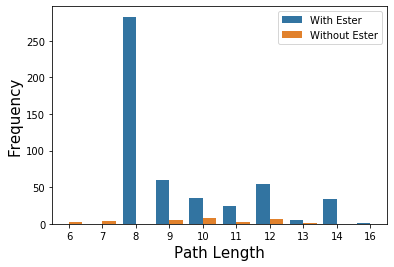

In [100]:
# Path Length
carbamic_frame = pd.DataFrame(pathsize, columns=["Path Length", "Ester"])
carbamic_group = carbamic_frame.groupby("Ester")
w_ester = carbamic_group.get_group(1)
wo_ester = carbamic_group.get_group(0)
w = w_ester["Path Length"].value_counts()
wo = wo_ester["Path Length"].value_counts()
carbamic_data = pd.DataFrame({"Path Length":list(w.index)+list(wo.index), "Frequency":list(w)+list(wo), 
                           "Ester": ["With Ester"]*len(w)+["Without Ester"]*len(wo)})
sns.barplot(data=carbamic_data, x="Path Length",y="Frequency", hue="Ester")
plt.legend(loc="upper right")
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("carbamic_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [101]:
# Carbamic Acid and Ester Bond Position Analysis
# Set maximum path length 15 for our analysis
carbamic_pos_analysis = [] 
ester_pos_analysis = []
for item in carbamic_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        carbamic_pos_analysis.append(pseudo)

for item in ester_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ester_pos_analysis.append(pseudo)

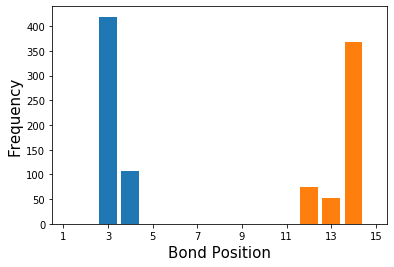

In [102]:
carbamic_frame = pd.DataFrame(carbamic_pos_analysis)
ester_frame = pd.DataFrame(ester_pos_analysis)
carbamic_frame_ = carbamic_frame.sum(axis=0)
ester_frame_ = ester_frame.sum(axis=0)
plt.bar(carbamic_frame_.index+1,carbamic_frame_)
plt.bar(ester_frame_.index+1,ester_frame_)
plt.xlim(0.5,15.5)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("carbamic_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

# Urea

In [8]:
urea_1 = Chem.MolFromSmarts("NC(=O)N")
urea_mol = []
urea_mol_inchi = []
for mol in unique_mol_pi_stack:
    pistack = entropy.GetPiPiStacking(mol)
    inchi = Chem.MolToInchiKey(mol)
    urea_match = mol.GetSubstructMatches(urea_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        urea_check = [p for p in urea_match if len(set(shortest_path).intersection(set(p)))==3]
        if any(urea_check) and (inchi not in urea_mol_inchi):
            urea_mol_inchi.append(inchi)
            urea_mol.append(mol)

<font size="5">Urea Pattern 1</font>

In [104]:
urea_smart = Chem.MolFromSmarts("[N;R][C;R](=O)[N;R]")
urea_amide = Chem.MolFromSmarts("[#6][N][C](=O)[#6]")
urea_pos = []
amide_pos = []
pathsize = []
for mol in urea_mol:
    pistack = entropy.GetPiPiStacking(mol)
    urea_match = mol.GetSubstructMatches(urea_smart)
    amide_match = mol.GetSubstructMatches(urea_amide)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        urea_check = [p for p in urea_match if len(set(shortest_path).intersection(set(p)))>=2]
        amide_check = [p for p in amide_match if len(set(shortest_path).intersection(set(p)))==3]
        urea_C = []
        amide_CN = []
        for u in urea_check:
            C = u[1]
            if (C in shortest_path) and (C not in urea_C): # avoid repeating
                urea_C.append(C)
        for am in amide_check:
            CN = sorted([am[1],am[2]])
            if (CN in path_bonds) and (CN not in amide_CN): # avoid repeating
                amide_CN.append(CN)
        if any(urea_C):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [shortest_path.index(C) for C in urea_C]
            backward_index = [len(shortest_path)-idx for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                path_bonds.reverse()
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp, len(path_bonds)])
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            urea_pos.append([outcome, len(shortest_path)])

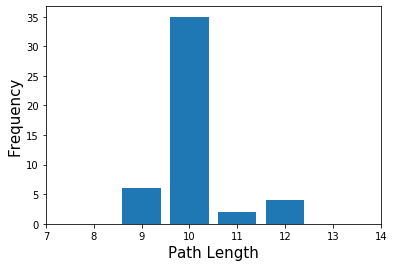

In [105]:
# Path Length
urea_frame = pd.DataFrame(pathsize, columns=["Path Length", "Amide"])
# No Amide
urea_path_length = urea_frame["Path Length"].value_counts()
plt.bar(urea_path_length.index,height=urea_path_length)
plt.xticks(np.arange(7,15,1))
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("urea_p1_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [106]:
# Urea Carbon Position Analysis
# Set maximum path length 15 for our analysis
urea_pos_analysis = [] 
for item in urea_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        urea_pos_analysis.append(pseudo)


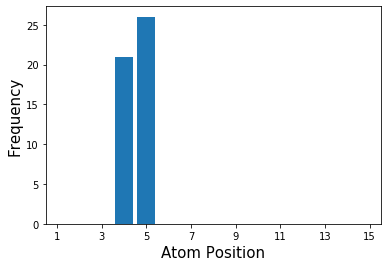

In [107]:
urea_frame = pd.DataFrame(urea_pos_analysis)
urea_frame_ = urea_frame.sum(axis=0)
plt.bar(urea_frame_.index+1,urea_frame_)
plt.xlim(0.5,15.5)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("urea_p1_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

<font size="5">Urea Pattern 2</font>

In [108]:
urea_smart = Chem.MolFromSmarts("[N;R]!@;-[C](=O)[N;!R]")
urea_amide = Chem.MolFromSmarts("[#6][N][C](=O)[#6]")
urea_pos = []
amide_pos = []
pathsize = []
for mol in urea_mol:
    pistack = entropy.GetPiPiStacking(mol)
    urea_match = mol.GetSubstructMatches(urea_smart)
    amide_match = mol.GetSubstructMatches(urea_amide)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        urea_check = [p for p in urea_match if len(set(shortest_path).intersection(set(p)))>=2]
        amide_check = [p for p in amide_match if len(set(shortest_path).intersection(set(p)))>=3]
        urea_C = []
        amide_CN = []
        for u in urea_check:
            C = u[1]
            if (C in shortest_path) and (C not in urea_C): # avoid repeating
                urea_C.append(C)
        for am in amide_check:
            CN = sorted([am[1],am[2]])
            if (CN in path_bonds) and (CN not in amide_CN): # avoid repeating
                amide_CN.append(CN)
        if any(urea_C):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [shortest_path.index(C) for C in urea_C]
            backward_index = [len(shortest_path)-idx for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                path_bonds.reverse()
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp, len(path_bonds)])
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            urea_pos.append([outcome, len(shortest_path)])

In [109]:
# Urea Carbon Position Analysis
# Set maximum atom path length 16 for our analysis
urea_pos_analysis = [] 
for item in urea_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        urea_pos_analysis.append(pseudo)

# Urea CN bond position 
# Set maximum bond path length 15 for our analysis
amide_pos_analysis = [] 
for item in amide_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_pos_analysis.append(pseudo)

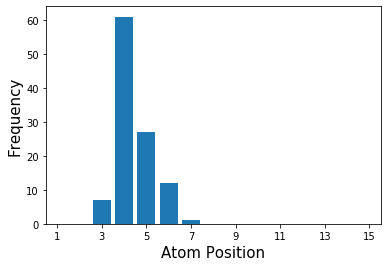

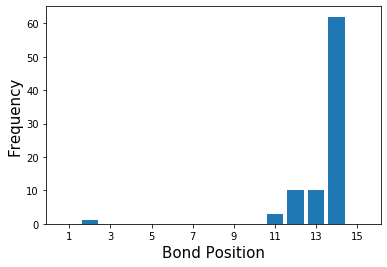

In [110]:
urea_frame = pd.DataFrame(urea_pos_analysis)
urea_frame_ = urea_frame.sum(axis=0)
plt.bar(urea_frame_.index+1,urea_frame_)
plt.xlim(0.5,15.5)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("urea_p2_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

amide_frame = pd.DataFrame(amide_pos_analysis)
amide_frame_ = amide_frame.sum(axis=0)
plt.bar(amide_frame_.index+1,amide_frame_)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("urea_p2_amide_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

<font size="5">Urea Pattern 3</font>



In [111]:
urea_smart = Chem.MolFromSmarts("[N;!R]!@;-[C;!R](=O)[N;!R]")
urea_amide = Chem.MolFromSmarts("[#6][N][C](=O)[#6]")
urea_pos = []
amide_pos = []
pathsize = []
for mol in urea_mol:
    pistack = entropy.GetPiPiStacking(mol)
    urea_match = mol.GetSubstructMatches(urea_smart)
    amide_match = mol.GetSubstructMatches(urea_amide)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        urea_check = [p for p in urea_match if len(set(shortest_path).intersection(set(p)))>=2]
        amide_check = [p for p in amide_match if len(set(shortest_path).intersection(set(p)))>=3]
        urea_C = []
        amide_CN = []
        for u in urea_check:
            C = u[1]
            if (C in shortest_path) and (C not in urea_C): # avoid repeating
                urea_C.append(C)
        for am in amide_check:
            CN = sorted([am[1],am[2]])
            if (CN in path_bonds) and (CN not in amide_CN): # avoid repeating
                amide_CN.append(CN)
        if any(urea_C):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [shortest_path.index(C) for C in urea_C]
            backward_index = [len(shortest_path)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                path_bonds.reverse()
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp, len(path_bonds)])
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            urea_pos.append([outcome, len(shortest_path)])

In [112]:
# Urea Carbon Position Analysis
# Set maximum atom path length 16 for our analysis
urea_pos_analysis = [] 
for item in urea_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        urea_pos_analysis.append(pseudo)

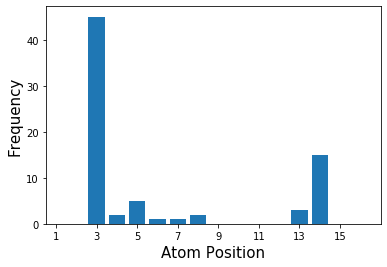

In [113]:
urea_frame = pd.DataFrame(urea_pos_analysis)
urea_frame_ = urea_frame.sum(axis=0)
plt.bar(urea_frame_.index+1,urea_frame_)
plt.xlim(0.5,17)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("urea_p3_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

# Ketone

In [9]:
ketone = Chem.MolFromSmarts("[#6][C](=O)[#6]")
ketone_mol = []
ketone_mol_inchi = []
for mol in unique_mol_pi_stack:
    output = entropy.GetPiPiStacking(mol)
    ketonematch = mol.GetSubstructMatches(ketone)
    for out in output:
        path = entropy.GetShortestPathBetweenRing(mol, out[0], out[1])
        km = [len(set(x).intersection(set(path)))==3 for x in ketonematch]
        if any(km):
            if Chem.MolToInchiKey(mol) not in ketone_mol_inchi:
                ketone_mol_inchi.append(Chem.MolToInchiKey(mol))
                ketone_mol.append(mol)

In [115]:
ketone_smart = Chem.MolFromSmarts("[#6][C](=O)[#6]")
ketone_ether = Chem.MolFromSmarts("[#6&!$([C](=O))][O][#6&!$([C](=O))]")
ketone_ester = Chem.MolFromSmarts("[#6][O][C](=O)[#6]")
ketone_pos = []
ester_pos = []
ether_pos = []
pathsize = []
mols = []
for mol in ketone_mol:
    pistack = entropy.GetPiPiStacking(mol)
    ketone_match = mol.GetSubstructMatches(ketone_smart)
    ester_match = mol.GetSubstructMatches(ketone_ester)
    ether_match = mol.GetSubstructMatches(ketone_ether)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        ketone_check = [p for p in ketone_match if len(set(shortest_path).intersection(set(p)))==3]
        ester_check = [p for p in ester_match if len(set(shortest_path).intersection(set(p)))==4]
        ether_check = [p for p in ether_match if len(set(shortest_path).intersection(set(p)))==3]
        ketone_C = []
        ether_O = []
        ester_CO = []
        for u in ketone_check:
            C = u[1]
            if (C in shortest_path) and (C not in ketone_C): # avoid repeating
                ketone_C.append(C)
        for u in ether_check:
            Oxy = u[1]
            if (Oxy in shortest_path) and (Oxy not in ketone_C): # avoid repeating
                ether_O.append(Oxy)
        for es in ester_check:
            CO = sorted([es[1],es[2]])
            if (CO in path_bonds) and (CO not in ester_CO): # avoid repeating
                ester_CO.append(CO)
        if any(ketone_C):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [shortest_path.index(C) for C in ketone_C]
            backward_index = [len(shortest_path)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if (any(ester_CO)) and (any(ether_O)):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp,len(path_bonds)])           
                    tmp = list(set([shortest_path.index(Oxy) for Oxy in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])  
                    pathsize.append([len(path_bonds),3])
                elif (any(ether_O)) and (len(ester_CO)==0):
                    tmp = list(set([shortest_path.index(Oxy) for Oxy in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])           
                    pathsize.append([len(path_bonds),1])
                    mols.append(mol)
                elif (any(ester_CO)) and (len(ether_O)==0):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),2])
                else:
                    pathsize.append([len(path_bonds),0])
                
            else:
                outcome = backward_index
                path_bonds.reverse()
                if (any(ester_CO)) and (any(ether_O)):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp,len(path_bonds)])           
                    tmp = list(set([len(shortest_path)-shortest_path.index(Oxy)-1 for O in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])  
                    pathsize.append([len(path_bonds),3])
                elif (any(ether_O)) and (len(ester_CO)==0):
                    tmp = list(set([len(shortest_path)-shortest_path.index(Oxy)-1 for O in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])           
                    pathsize.append([len(path_bonds),1])
                    mols.append(mol)
                elif (any(ester_CO)) and (len(ether_O)==0):
                    tmp = list(set([path_bonds.index(CO) for CO in ester_CO]))
                    ester_pos.append([tmp,len(path_bonds)])           
                    pathsize.append([len(path_bonds),2])
                else:
                    pathsize.append([len(path_bonds),0])
            ketone_pos.append([outcome, len(shortest_path)])

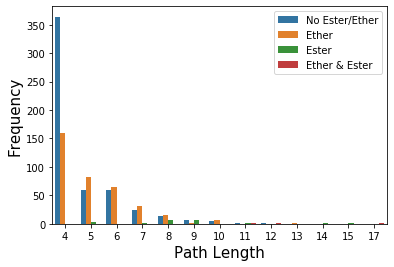

In [116]:
# Path Length
ketone_frame = pd.DataFrame(pathsize, columns=["Path Length", "Functional Group"])
ketone_group = ketone_frame.groupby("Functional Group")
w_mix = ketone_group.get_group(3)
w_ester = ketone_group.get_group(2)
w_ether = ketone_group.get_group(1)
ketone_only = ketone_group.get_group(0)
w1 = ketone_only["Path Length"].value_counts()
w2 = w_ether["Path Length"].value_counts()
w3 = w_ester["Path Length"].value_counts()
w4 = w_mix["Path Length"].value_counts()
ketone_data = pd.DataFrame({"Path Length":list(w1.index)+list(w2.index)+list(w3.index)+list(w4.index),
                            "Frequency":list(w1)+list(w2)+list(w3)+list(w4), 
                           "Functional Group": ["No Ester/Ether"]*len(w1)+["Ether"]*len(w2)+["Ester"]*len(w3)+["Ether & Ester"]*len(w4)})

sns.barplot(data=ketone_data, x="Path Length",y="Frequency", hue="Functional Group")
plt.legend(loc="upper right")
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ketone_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [117]:
# Ketone C position analysis (maximum 16 atoms path)
ketone_pos_analysis = [] 
for item in ketone_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ketone_pos_analysis.append(pseudo)
        
# Ester CO position analysis (maximum 15 bond path)
ester_pos_analysis = [] 
for item in ester_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ester_pos_analysis.append(pseudo)

# Ether O position analysis (maximum 16 atoms path)
ether_pos_analysis = [] 
for item in ether_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ether_pos_analysis.append(pseudo)


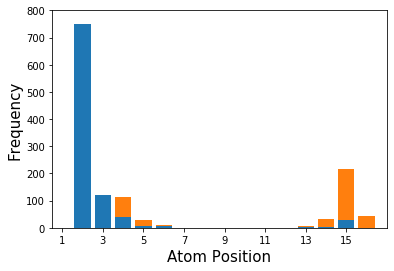

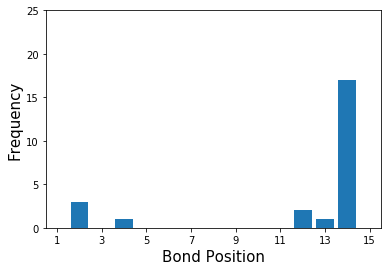

In [94]:
ketone_frame = pd.DataFrame(ketone_pos_analysis)
ketone_frame_ = ketone_frame.sum(axis=0)
ether_frame = pd.DataFrame(ether_pos_analysis)
ether_frame_ = ether_frame.sum(axis=0)
plt.bar(ketone_frame_.index+1,ketone_frame_, label="Ketone")
plt.bar(ether_frame_.index+1,ether_frame_,bottom=ketone_frame_, label="Ether")
plt.xlim(0.5,17)
plt.ylim(0,800)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ketone_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()


ester_frame = pd.DataFrame(ester_pos_analysis)
ester_frame_ = ester_frame.sum(axis=0)
plt.bar(ester_frame_.index+1,ester_frame_, label="Ketone")
plt.xlim(0.5,15.5)
plt.ylim(0,25)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ketone_ester_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()


# Ester

In [12]:
# Inchi Key for urea, carbamic acid and ketone
urea_inchi = [Chem.MolToInchiKey(mol) for mol in urea_mol]
carbamic_inchi = [Chem.MolToInchiKey(mol) for mol in carbamic_mol]
ketone_inchi = [Chem.MolToInchiKey(mol) for mol in ketone_mol]
mixinchi = urea_inchi+carbamic_inchi+ketone_inchi

In [13]:
# Only consider Ester with out keton, ester and carbamic acid in the shortest path
ester_1 = Chem.MolFromSmarts("[#6][C](=O)[O][#6]")
ester_mol = []
ester_mol_inchi = []
for mol in unique_mol_pi_stack:
    pistack = entropy.GetPiPiStacking(mol)
    inchi = Chem.MolToInchiKey(mol)
    ester_match = mol.GetSubstructMatches(ester_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        ester_check = [p for p in ester_match if len(set(shortest_path).intersection(set(p)))==4]
        if any(ester_check) and (inchi not in ester_mol_inchi) and (inchi not in mixinchi):
            ester_mol_inchi.append(inchi)
            ester_mol.append(mol)

In [168]:
ester_smart = Chem.MolFromSmarts("[#6][C](=O)[O][#6]")
sulfonamide = Chem.MolFromSmarts("[N][S](=O)(=O)")
ester_ether = Chem.MolFromSmarts("[#6&!$([C](=O))][O][#6&!$([C](=O))]")
ester_pos = []
sulfonamide_pos = []
ether_pos = []
pathsize = []
for mol in ester_mol:
    pistack = entropy.GetPiPiStacking(mol)
    ester_match = mol.GetSubstructMatches(ester_smart)
    sulfonamide_match = mol.GetSubstructMatches(sulfonamide)
    ether_match = mol.GetSubstructMatches(ester_ether)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        ester_check = [p for p in ester_match if len(set(shortest_path).intersection(set(p)))==4]
        ether_check = [p for p in ether_match if len(set(shortest_path).intersection(set(p)))==3]
        sulfonamide_check = [p for p in sulfonamide_match if len(set(shortest_path).intersection(set(p)))==2]
        ester_CO = []
        sulfonamide_NS = []
        ether_O = []
        for co in ester_check:
            CO = sorted([co[1],co[3]])
            if (CO in path_bonds) and (CO not in ester_CO): # avoid repeating
                ester_CO.append(CO)
        for ns in sulfonamide_check:
            NS = sorted([ns[0],ns[1]])
            if (NS in path_bonds) and (NS not in sulfonamide_NS): # avoid repeating
                sulfonamide_NS.append(NS)   
        for oo in ether_check:
            O = oo[1]
            if (O in shortest_path) and (O not in ether_O): # avoid repeating
                ether_O.append(O)   
        if any(ester_CO):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [path_bonds.index(CO) for CO in ester_CO]
            backward_index = [len(path_bonds)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(sulfonamide_NS) and len(ether_O)==0:
                    tmp = list(set([path_bonds.index(NS) for NS in sulfonamide_NS]))
                    sulfonamide_pos.append([tmp,len(path_bonds)])  
                    pathsize.append([len(path_bonds),1])
                elif any(ether_O) and len(sulfonamide_NS)==0:
                    tmp = list(set([shortest_path.index(O) for O in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])  
                    pathsize.append([len(path_bonds),2])
                else:
                    pathsize.append([len(path_bonds),0])
                
            else:
                outcome = backward_index
                path_bonds.reverse()
                re_path = list(shortest_path)
                re_path.reverse()
                if any(sulfonamide_NS):
                    tmp = list(set([path_bonds.index(NS) for NS in sulfonamide_NS]))
                    sulfonamide_pos.append([tmp,len(path_bonds)])  
                    pathsize.append([len(path_bonds),1])
                elif any(ether_O) and len(sulfonamide_NS)==0:
                    tmp = list(set([re_path.index(O) for O in ether_O]))
                    ether_pos.append([tmp,len(shortest_path)])  
                    pathsize.append([len(path_bonds),2])
                else:
                    pathsize.append([len(path_bonds),0])
            ester_pos.append([outcome, len(path_bonds)])

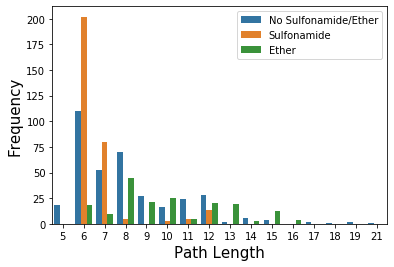

In [170]:
# Path Length
ester_frame = pd.DataFrame(pathsize, columns=["Path Length", "Functional Group"])
ester_group = ester_frame.groupby("Functional Group")
w_ether = ester_group.get_group(2)
w_sulfonamide = ester_group.get_group(1)
ester_only = ester_group.get_group(0)
w1 = ester_only["Path Length"].value_counts()
w2 = w_sulfonamide["Path Length"].value_counts()
w3 = w_ether["Path Length"].value_counts()
ester_data = pd.DataFrame({"Path Length":list(w1.index)+list(w2.index)+list(w3.index),
                            "Frequency":list(w1)+list(w2)+list(w3), 
                           "Functional Group": ["No Sulfonamide/Ether"]*len(w1)+["Sulfonamide"]*len(w2)+["Ether"]*len(w3)})

sns.barplot(data=ester_data, x="Path Length",y="Frequency", hue="Functional Group")
plt.legend(loc="upper right")
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ester_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [171]:
# Ester CO bond position analysis (maximum 15 bond path length)
ester_pos_analysis = [] 
for item in ester_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ester_pos_analysis.append(pseudo)
        
# sulfonamide NS position analysis (maximum 15 bond path)
sulfonamide_pos_analysis = [] 
for item in sulfonamide_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        sulfonamide_pos_analysis.append(pseudo)

# Ether O position analysis (maximum 16 atoms path)
ether_pos_analysis = [] 
for item in ether_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ether_pos_analysis.append(pseudo)


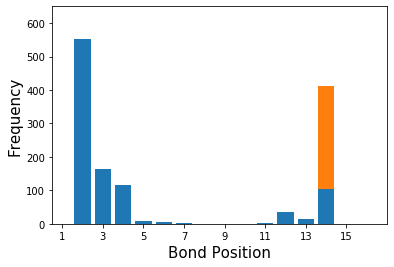

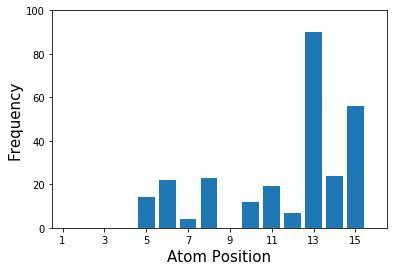

In [172]:
ester_frame = pd.DataFrame(ester_pos_analysis)
ester_frame_ = ester_frame.sum(axis=0)
sulfonamide_frame = pd.DataFrame(sulfonamide_pos_analysis)
sulfonamide_frame_ = sulfonamide_frame.sum(axis=0)
plt.bar(ester_frame_.index+1,ester_frame_, label="ester")
plt.bar(sulfonamide_frame_.index+1,sulfonamide_frame_,bottom=ester_frame_, label="sulfonamide")
plt.xlim(0.5,17)
plt.ylim(0,650)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ester_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

ether_frame = pd.DataFrame(ether_pos_analysis)
ether_frame_ = ether_frame.sum(axis=0)
plt.bar(ether_frame_.index+1,ether_frame_, label="ether")
plt.xlim(0.5,16.5)
plt.ylim(0,100)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ester_ether_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

# Ether

In [14]:
# Inchi Key for urea, carbamic acid and ketone
urea_inchi = [Chem.MolToInchiKey(mol) for mol in urea_mol]
carbamic_inchi = [Chem.MolToInchiKey(mol) for mol in carbamic_mol]
ketone_inchi = [Chem.MolToInchiKey(mol) for mol in ketone_mol]
ester_inchi = [Chem.MolToInchiKey(mol) for mol in ester_mol]
mixinchi = urea_inchi+carbamic_inchi+ketone_inchi+ester_inchi

In [15]:
ether_1 = Chem.MolFromSmarts("[#6&!$([C](=O))][O][#6&!$([C](=O))]")
ether_mol = []
ether_mol_inchi = []
for mol in unique_mol_pi_stack:
    pistack = entropy.GetPiPiStacking(mol)
    inchi = Chem.MolToInchiKey(mol)
    ether_match = mol.GetSubstructMatches(ether_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        ether_check = [p for p in ether_match if len(set(shortest_path).intersection(set(p)))==3]
        if any(ether_check) and (inchi not in ether_mol_inchi) and (inchi not in mixinchi):
            ether_mol_inchi.append(inchi)
            ether_mol.append(mol)

In [187]:
ether_smart = Chem.MolFromSmarts("[#6&!$([C](=O))][O][#6&!$([C](=O))]")
ether_amide = Chem.MolFromSmarts("[#6][N][C](=O)[#6]")
ether_pos = []
amide_pos = []
pathsize = []
for mol in ether_mol:
    pistack = entropy.GetPiPiStacking(mol)
    ether_match = mol.GetSubstructMatches(ether_smart)
    amide_match = mol.GetSubstructMatches(ether_amide)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        ether_check = [p for p in ether_match if len(set(shortest_path).intersection(set(p)))==3]
        amide_check = [p for p in amide_match if len(set(shortest_path).intersection(set(p)))==4]
        amide_CN = []
        ether_O = []
        for cn in amide_check:
            CN = sorted([cn[1],cn[2]])
            if (CN in path_bonds) and (CN not in amide_CN): # avoid repeating
                amide_CN.append(CN)   
        for oo in ether_check:
            O = oo[1]
            if (O in shortest_path) and (O not in ether_O): # avoid repeating
                ether_O.append(O)   
        if any(ether_O):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [shortest_path.index(O) for O in ether_O]
            backward_index = [len(shortest_path)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp,len(path_bonds)])  
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                path_bonds.reverse()
                re_path = list(shortest_path)
                re_path.reverse()
                if any(amide_CN):
                    tmp = list(set([path_bonds.index(CN) for CN in amide_CN]))
                    amide_pos.append([tmp,len(path_bonds)])  
                    pathsize.append([len(path_bonds),1])
                else:
                    pathsize.append([len(path_bonds),0])
            ether_pos.append([outcome, len(shortest_path)])

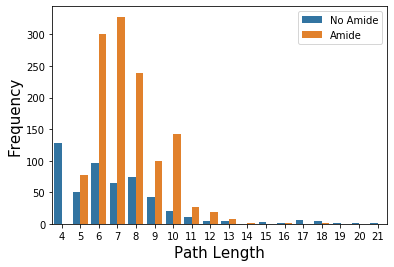

In [205]:
# Path Length
ether_frame = pd.DataFrame(pathsize, columns=["Path Length", "Functional Group"])
ether_group = ether_frame.groupby("Functional Group")
w_amide = ether_group.get_group(1)
ether_only = ether_group.get_group(0)
w1 = ether_only["Path Length"].value_counts()
w2 = w_amide["Path Length"].value_counts()
ether_data = pd.DataFrame({"Path Length":list(w1.index)+list(w2.index),
                            "Frequency":list(w1)+list(w2), 
                           "Functional Group": ["No Amide"]*len(w1)+["Amide"]*len(w2)})

sns.barplot(data=ether_data, x="Path Length",y="Frequency", hue="Functional Group")
plt.legend(loc="upper right")
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ether_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [190]:
ether_pos_analysis = [] 
for item in ether_pos:
    pseudo = [0]*16
    if item[1]>16:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,16-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        ether_pos_analysis.append(pseudo)
        
# amide NS position analysis (maximum 15 bond path)
amide_pos_analysis = [] 
for item in amide_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_pos_analysis.append(pseudo)


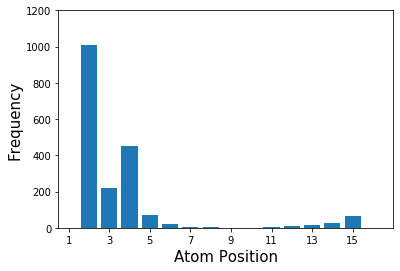

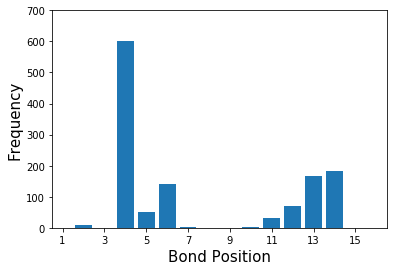

In [208]:
ether_frame = pd.DataFrame(ether_pos_analysis)
ether_frame_ = ether_frame.sum(axis=0)
plt.bar(ether_frame_.index+1,ether_frame_, label="ether")
plt.xlim(0.5,17)
plt.ylim(0,1200)
plt.xticks(np.arange(1,17,2))
plt.xlabel("Atom Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ether_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

amide_frame = pd.DataFrame(amide_pos_analysis)
amide_frame_ = amide_frame.sum(axis=0)
plt.bar(amide_frame_.index+1,amide_frame_, label="amide")
plt.xlim(0.5,16.5)
plt.ylim(0,700)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("ester_amide_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

# Amide

In [16]:
# Inchi Key for urea, carbamic acid and ketone
urea_inchi = [Chem.MolToInchiKey(mol) for mol in urea_mol]
carbamic_inchi = [Chem.MolToInchiKey(mol) for mol in carbamic_mol]
ketone_inchi = [Chem.MolToInchiKey(mol) for mol in ketone_mol]
ester_inchi = [Chem.MolToInchiKey(mol) for mol in ester_mol]
ether_inchi = [Chem.MolToInchiKey(mol) for mol in ether_mol]
mixinchi = urea_inchi+carbamic_inchi+ketone_inchi+ester_inchi+ether_inchi

In [17]:
amide_1 = Chem.MolFromSmarts("[#6][N][C](=O)[#6]")
amide_mol = []
amide_mol_inchi = []
for mol in unique_mol_pi_stack:
    pistack = entropy.GetPiPiStacking(mol)
    inchi = Chem.MolToInchiKey(mol)
    amide_match = mol.GetSubstructMatches(amide_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        amide_check = [p for p in amide_match if len(set(shortest_path).intersection(set(p)))==4]
        if any(amide_check) and (inchi not in amide_mol_inchi) and (inchi not in mixinchi):
            amide_mol_inchi.append(inchi)
            amide_mol.append(mol)

In [25]:
linear_chain = []
mix_chain = []
for mol in amide_mol:
    pistack = entropy.GetPiPiStacking(mol)
    tmp = []
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        tmp.append(any([mol.GetAtomWithIdx(x).IsInRing() for x in range(1,len(shortest_path)-1)]))
    if any(tmp):
        mix_chain.append(mol)
    else:
        linear_chain.append(mol)

In [40]:
amide_smart_1 = Chem.MolFromSmarts("[#6][N;!R][C;!R](=O)[#6]")
amide_pos = []
pathsize = []
for mol in linear_chain:
    pistack = entropy.GetPiPiStacking(mol)
    amide_1_match = mol.GetSubstructMatches(amide_smart_1)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        amide_1_check = [p for p in amide_1_match if len(set(shortest_path).intersection(set(p)))==4]
        amide_1_CN = []
        for cn in amide_1_check:
            CN = sorted([cn[1],cn[2]])
            if (CN in path_bonds) and (CN not in amide_1_CN): # avoid repeating
                amide_1_CN.append(CN)       
        if any(amide_1_CN):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [path_bonds.index(CN) for CN in amide_1_CN]
            backward_index = [len(path_bonds)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                amide_pos.append([outcome, len(path_bonds)])
                pathsize.append(len(path_bonds))
            else:
                outcome = backward_index
                amide_pos.append([outcome, len(path_bonds)])
                pathsize.append(len(path_bonds))

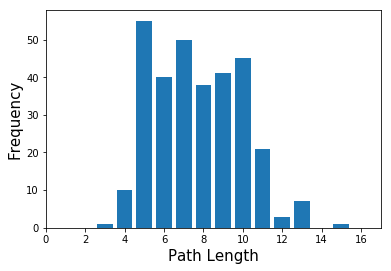

In [51]:
# Path Length
amide_frame = pd.DataFrame(pathsize, columns=["Path Length"])
amide_count = amide_frame["Path Length"].value_counts()
plt.bar(amide_count.index,amide_count)
plt.xlim(0,17)
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("amide_1_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [47]:
# amide NS position analysis (maximum 15 bond path)
amide_pos_analysis = [] 
for item in amide_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_pos_analysis.append(pseudo)

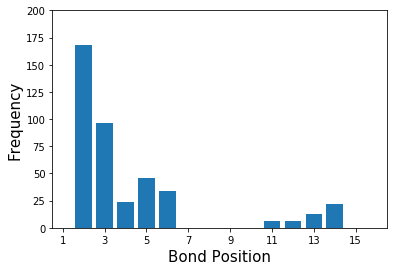

In [50]:
amide_frame = pd.DataFrame(amide_pos_analysis)
amide_frame_ = amide_frame.sum(axis=0)
plt.bar(amide_frame_.index+1,amide_frame_, label="amide")
plt.xlim(0.5,16.5)
plt.ylim(0,200)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("amide_1_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [104]:
amide_smart_1 = Chem.MolFromSmarts("[#6][N;R]@[C;R](=O)[#6]")
amide_smart_2 = Chem.MolFromSmarts("[#6][N;R][C;!R](=O)[#6]")
amide_smart_3 = Chem.MolFromSmarts("[#6][N;!R][C;!R](=O)[#6]")
amide_1_pos = []
amide_2_pos = []
amide_1_3_pos = []
amide_2_3_pos = []
amide_3_pos = []
pathsize = []
for mol in mix_chain:
    pistack = entropy.GetPiPiStacking(mol)
    amide_1_match = mol.GetSubstructMatches(amide_smart_1)
    amide_2_match = mol.GetSubstructMatches(amide_smart_2)
    amide_3_match = mol.GetSubstructMatches(amide_smart_3)
    for pi in pistack:
        shortest_path = entropy.GetShortestPathBetweenRing(mol, pi[0], pi[1])
        path_bonds = [sorted([shortest_path[i], shortest_path[i+1]]) for i in range(len(shortest_path)-1)]
        amide_1_check = [p for p in amide_1_match if len(set(shortest_path).intersection(set(p)))==4]
        amide_2_check = [p for p in amide_2_match if len(set(shortest_path).intersection(set(p)))==4]
        amide_3_check = [p for p in amide_3_match if len(set(shortest_path).intersection(set(p)))==4]
        amide_1_CN = []
        amide_2_CN = []
        amide_3_CN = []
        for cn in amide_1_check:
            CN = sorted([cn[1],cn[2]])
            if (CN in path_bonds) and (CN not in amide_1_CN): # avoid repeating
                amide_1_CN.append(CN)   
        for cn in amide_2_check:
            CN = sorted([cn[1],cn[2]])
            if (CN in path_bonds) and (CN not in amide_2_CN): # avoid repeating
                amide_2_CN.append(CN)   
        for cn in amide_3_check:
            CN = sorted([cn[1],cn[2]])
            if (CN in path_bonds) and (CN not in amide_3_CN): # avoid repeating
                amide_3_CN.append(CN)   
        
        if any(amide_1_CN):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [path_bonds.index(CN) for CN in amide_1_CN]
            backward_index = [len(path_bonds)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                amide_1_pos.append([forward_index,len(path_bonds)])  
                if any(amide_3_CN):
                    pathsize.append([len(path_bonds),1])
                    tmp = [path_bonds.index(CN) for CN in amide_3_CN]
                    amide_1_3_pos.append([tmp, len(path_bonds)])
                else:
                    pathsize.append([len(path_bonds),0])
            else:
                outcome = backward_index
                amide_1_pos.append([backward_index,len(path_bonds)])  
                path_bonds.reverse()
                if any(amide_3_CN):
                    pathsize.append([len(path_bonds),1])
                    tmp = [path_bonds.index(CN) for CN in amide_3_CN]
                    amide_1_3_pos.append([tmp, len(path_bonds)])
                else:
                    pathsize.append([len(path_bonds),0])
        elif any(amide_2_CN):
            # Determine the pi-pi stacking order A-->B or B-->A
            forward_index = [path_bonds.index(CN) for CN in amide_2_CN]
            backward_index = [len(path_bonds)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
                amide_2_pos.append([forward_index,len(path_bonds)])  
                pathsize.append([len(path_bonds),1])
                if any(amide_3_CN):
                    tmp = [path_bonds.index(CN) for CN in amide_3_CN]
                    amide_2_3_pos.append([tmp, len(path_bonds)])
                                    
            else:
                outcome = backward_index
                amide_2_pos.append([backward_index,len(path_bonds)])  
                path_bonds.reverse()
                pathsize.append([len(path_bonds),2])
                if any(amide_3_CN):
                    tmp = [path_bonds.index(CN) for CN in amide_3_CN]
                    amide_2_3_pos.append([tmp, len(path_bonds)])
                    
        elif any(amide_3_CN):
            forward_index = [path_bonds.index(CN) for CN in amide_3_CN]
            backward_index = [len(path_bonds)-idx-1 for idx in forward_index]
            if min(forward_index)<=min(backward_index):
                outcome = forward_index
            else:
                outcome = backward_index
            pathsize.append([len(path_bonds),0])
            amide_3_pos.append([outcome, len(path_bonds)])
        else:
            continue

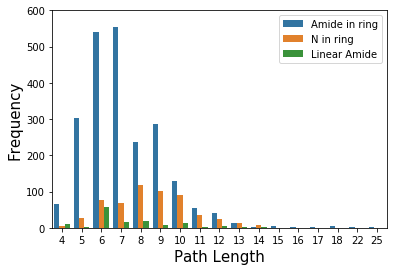

In [105]:
# Path Length
amide_frame = pd.DataFrame(pathsize, columns=["Path Length", "Form"])
amide_group = amide_frame.groupby("Form")
two = amide_group.get_group(2)
one = amide_group.get_group(1)
zero = amide_group.get_group(0)
w0 = zero["Path Length"].value_counts()
w1 = one["Path Length"].value_counts()
w2 = two["Path Length"].value_counts()
amide_data = pd.DataFrame({"Path Length":list(w0.index)+list(w1.index)+list(w2.index),
                            "Frequency":list(w0)+list(w1)+list(w2), 
                           "Form": ["Amide in ring"]*len(w0)+["N in ring"]*len(w1)+["Linear Amide"]*len(w2)})

sns.barplot(data=amide_data, x="Path Length",y="Frequency", hue="Form")
plt.legend(loc="upper right")
plt.xlabel("Path Length",size=15)
plt.ylabel("Frequency",size=15)
plt.ylim(0,600)
plt.savefig("amide_2_path_length.pdf",dpi=300,bbox_inches="tight")
plt.show()

In [106]:
# amide_1 NS position analysis (maximum 15 bond path)
amide_1_pos_analysis = [] 
for item in amide_1_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_1_pos_analysis.append(pseudo) 

amide_1_3_pos_analysis = [] 
for item in amide_1_3_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_1_3_pos_analysis.append(pseudo) 

        
        
amide_2_pos_analysis = [] 
for item in amide_2_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_2_pos_analysis.append(pseudo)

amide_2_3_pos_analysis = [] 
for item in amide_2_3_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_2_3_pos_analysis.append(pseudo)
        
    
amide_3_pos_analysis = [] 
for item in amide_3_pos:
    pseudo = [0]*15
    if item[1]>15:
        continue 
    else:
        half = int(np.floor(item[1]/2))
        if item[1]%2:
            start = half+1
        else:
            start = half
        for i in range(start,15-half):
            pseudo[i] = np.nan
        for j in item[0]:
            if j>half:
                pseudo[-(item[1]-j)] = 1
                
            else:
                pseudo[j] = 1
        amide_3_pos_analysis.append(pseudo)

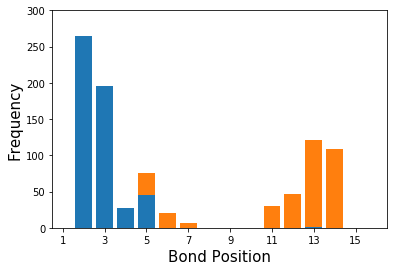

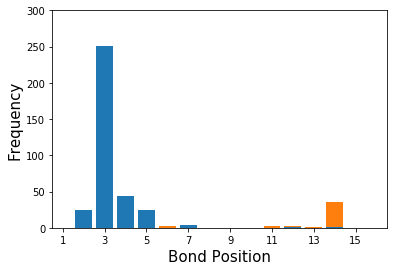

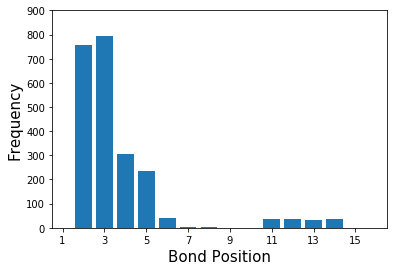

In [110]:
amide_1_frame = pd.DataFrame(amide_1_pos_analysis)
amide_1_frame_ = amide_1_frame.sum(axis=0)
amide_1_3_frame = pd.DataFrame(amide_1_3_pos_analysis)
amide_1_3_frame_ = amide_1_3_frame.sum(axis=0)
plt.bar(amide_1_frame_.index+1,amide_1_frame_)
plt.bar(amide_1_3_frame_.index+1,amide_1_3_frame_,bottom=amide_1_frame_,label="Linear Amide")
plt.xlim(0.5,16.5)
plt.ylim(0,300)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("amide_mix_1_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()


amide_2_frame = pd.DataFrame(amide_2_pos_analysis)
amide_2_frame_ = amide_2_frame.sum(axis=0)
amide_2_3_frame = pd.DataFrame(amide_2_3_pos_analysis)
amide_2_3_frame_ = amide_2_3_frame.sum(axis=0)
plt.bar(amide_2_frame_.index+1,amide_2_frame_)
plt.bar(amide_2_3_frame_.index+1,amide_2_3_frame_,bottom=amide_2_frame_,label="Linear Amide")
plt.xlim(0.5,16.5)
plt.ylim(0,300)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("amide_mix_2_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()


amide_3_frame = pd.DataFrame(amide_3_pos_analysis)
amide_3_frame_ = amide_3_frame.sum(axis=0)
plt.bar(amide_3_frame_.index+1,amide_3_frame_)
plt.xlim(0.5,16.5)
plt.ylim(0,900)
plt.xticks(np.arange(1,16,2))
plt.xlabel("Bond Position",size=15)
plt.ylabel("Frequency",size=15)
plt.savefig("amide_mix_3_position_analysis.pdf",dpi=300,bbox_inches="tight")
plt.show()

# Hydrogen Bond 


In [ ]:
def AmidePiStack(mol, ring1, ring2):
    """
    Determine the shortest path that will form pi-pi stacking
    """
    path = []
    
    
    
    return path

In [ ]:
def CalculateFoldability(mol):
    """
    Determine foldability of a molecule based on path length, functional groups and position of functional groups
    
    Functional Group:
    1. Carbamic Acid
    2. Urea
    3. Keton
    4. Ether
    5. Ester
    6. Amide
    """
    
    rotor = Chem.MolFromSmarts("[!$(*#*)&!D1]-!@[!$(*#*)&!D1]")

    
    
    foldability = []
    return foldability
    
    
    